In [16]:
%matplotlib inline

import itertools
import os

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import tensorflow as tf


from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing import text, sequence
from keras import utils
from sklearn.utils import class_weight
from keras.layers import Input, Dense, Dropout, Embedding, SpatialDropout1D, add, concatenate
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences

In [8]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 10*((precision*recall)/(precision+recall+K.epsilon()))


In [9]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [10]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [11]:
df = pd.read_csv('processed_v1.csv')
df =df.dropna()

In [12]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df.label_updated),
                                                 df.label_updated)

In [13]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
max_words = 50000
# Max number of words in each post.
max_sequence_length = 200
# This is fixed.
embedding_dim = 100
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['cleaned_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 92102 unique tokens.


In [17]:
x = tokenizer.texts_to_sequences(df['cleaned_text'].values)
x = pad_sequences(x, maxlen=max_sequence_length)
print('Shape of data tensor:', x.shape)
y = pd.get_dummies(df['label_updated']).values
print('Shape of label tensor:', y.shape)

Shape of data tensor: (113256, 200)
Shape of label tensor: (113256, 10)


In [18]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 500)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(90604, 200) (90604, 10)
(22652, 200) (22652, 10)


Train on 81543 samples, validate on 9061 samples
Epoch 1/5
81543/81543 [==============================] - 469s 6ms/step - loss: 1.6559 - acc: 0.4292 - precision_m: 0.5007 - recall_m: 0.1266 - f1_m: 0.1915 - val_loss: 1.5334 - val_acc: 0.4679 - val_precision_m: 0.6806 - val_recall_m: 0.1878 - val_f1_m: 0.2921
Epoch 2/5
81543/81543 [==============================] - 468s 6ms/step - loss: 1.4012 - acc: 0.5137 - precision_m: 0.6800 - recall_m: 0.3198 - f1_m: 0.4321 - val_loss: 1.4266 - val_acc: 0.5060 - val_precision_m: 0.6536 - val_recall_m: 0.3234 - val_f1_m: 0.4311
Epoch 3/5
81543/81543 [==============================] - 468s 6ms/step - loss: 1.2144 - acc: 0.5833 - precision_m: 0.7308 - recall_m: 0.4163 - f1_m: 0.5286 - val_loss: 1.4446 - val_acc: 0.4991 - val_precision_m: 0.6280 - val_recall_m: 0.3526 - val_f1_m: 0.4505
Epoch 4/5
81543/81543 [==============================] - 468s 6ms/step - loss: 1.0488 - acc: 0.6427 - precision_m: 0.7704 - recall_m: 0.5115 - f1_m: 0.6135 - val_loss: 

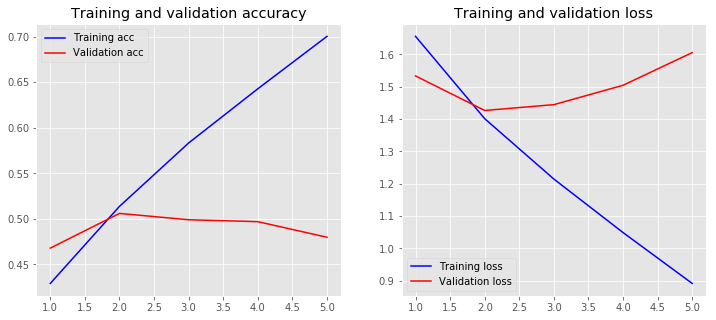

In [21]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=x.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy', precision_m, recall_m, f1_m])

epochs = 5
batch_size = 64

history = model.fit(x_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    class_weight=class_weights,                    
#                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
                   )
model.summary()
plot_history(history)

In [22]:
loss, accuracy, precision, recall, f1_score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
# print('Test accuracy:', score[1])
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)


22652/22652 [==============================] - 43s 2ms/step
Test loss: 1.587661783012762
Test accuracy: 0.48340102419212433
Test precision: 0.5622717874559143
Test recall: 0.3849549708371867
Test f1_score: 0.45623071877732835


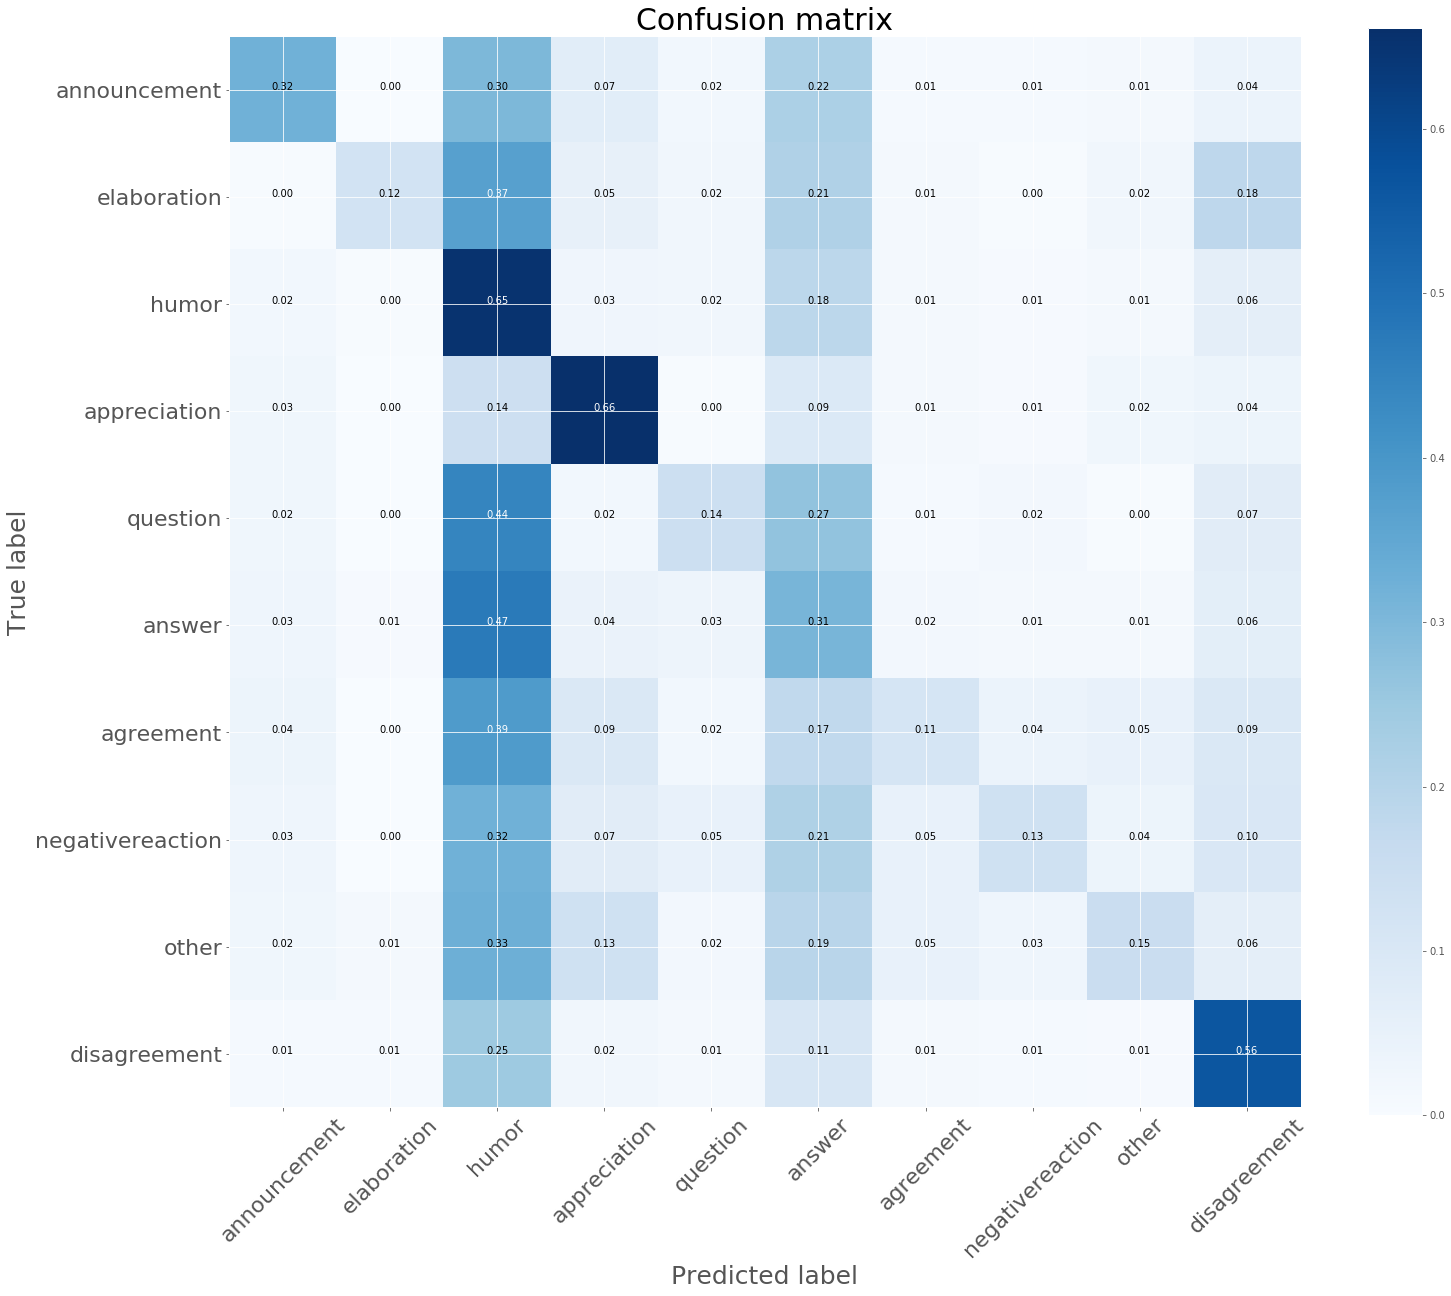

In [23]:
my_labels = ['announcement', 'elaboration', 'humor', 'appreciation', 'question',
       'answer', 'agreement', 'negativereaction', 'other', 'disagreement']

y_cm = model.predict(x_test)

y_test_cm = []
y_pred_cm = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_cm.append(one_hot_index)

for i in range(0, len(y_cm)):
    probs = y_cm[i]
    predicted_index = np.argmax(probs)
    y_pred_cm.append(predicted_index)

cnf_matrix = confusion_matrix(y_test_cm, y_pred_cm)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=my_labels, title="Confusion matrix")
plt.show()